In [12]:
!pip install keras
!pip install tensorflow

# Importando Bibliotecas

In [13]:
# importando as bibliotecas
import numpy as np
import random
import matplotlib.pyplot as plt
import os

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

%matplotlib inline

AttributeError: module 'tensorflow.python.util.dispatch' has no attribute 'add_fallback_dispatch_list'

In [20]:
# Definição de Parametros

im_shape = (250,250)

TRAINING_DIR = os.getcwd() + '\\Training'
TEST_DIR = os.getcwd() + '\\Testing'

seed = 21

BATCH_SIZE = 16

In [21]:
# Keras ImageGenerator and flow_from_directoty

# Subdivision in test/validation
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [22]:
# Generator para parte train
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Generator para parte validação
validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Generator para dataset de teste
test_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


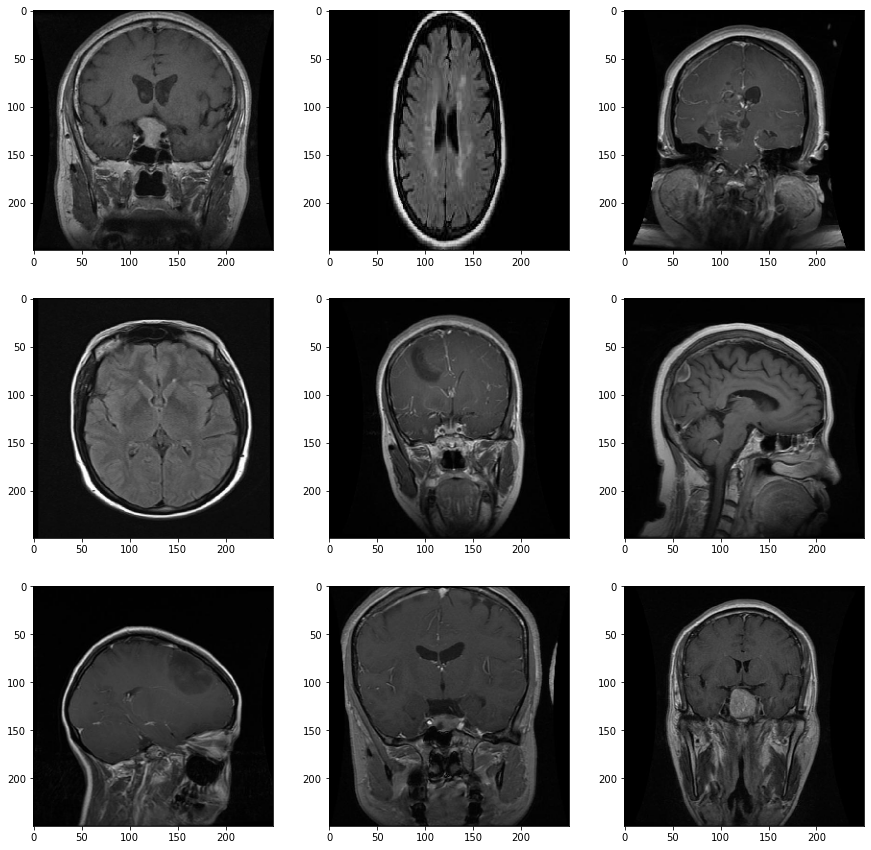

In [23]:
# Visualização de Exemplos dos dados

plt.figure(figsize=(15,15))
for i in range(9):
    #gera subfigures
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [24]:
# Criando molelo

model = Sequential()
model.add(Conv2D(20, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(im_shape[0],im_shape[1],3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(80, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(40, kernel_size=(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

# Compila o modelo
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),

              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 20)      560       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 20)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 80)      14480     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 120, 40)      28840     
_________________________________________________________________
flatten (Flatten)            (None, 576000)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               294912512 
_________________________________________________________________
dropout (Dropout)            (None, 512)               0

In [25]:
# Treinamento do Modelo

epochs = 50

# Callback para salvar o melhor modelo, parametro validation_loss

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/80
285/285 [==============================] - ETA: 0s - loss: 0.7684 - accuracy: 0.7809
Epoch 00001: val_loss improved from inf to 0.70164, saving model to model.h5
285/285 [==============================] - 496s 2s/step - loss: 0.7684 - accuracy: 0.7809 - val_loss: 0.7016 - val_accuracy: 0.7782
Epoch 2/80
285/285 [==============================] - ETA: 0s - loss: 0.1778 - accuracy: 0.9346
Epoch 00002: val_loss did not improve from 0.70164
285/285 [==============================] - 491s 2s/step - loss: 0.1778 - accuracy: 0.9346 - val_loss: 0.7583 - val_accuracy: 0.7597
Epoch 3/80
285/285 [==============================] - ETA: 0s - loss: 0.0654 - accuracy: 0.9796
Epoch 00003: val_loss did not improve from 0.70164
285/285 [==============================] - 495s 2s/step - loss: 0.0654 - accuracy: 0.9796 - val_loss: 0.9207 - val_accuracy: 0.7764
Epoch 4/80
285/285 [==============================] - ETA: 0s - loss: 0.0412 - accuracy: 0.9855
Epoch 00004: val_loss did not improve fro

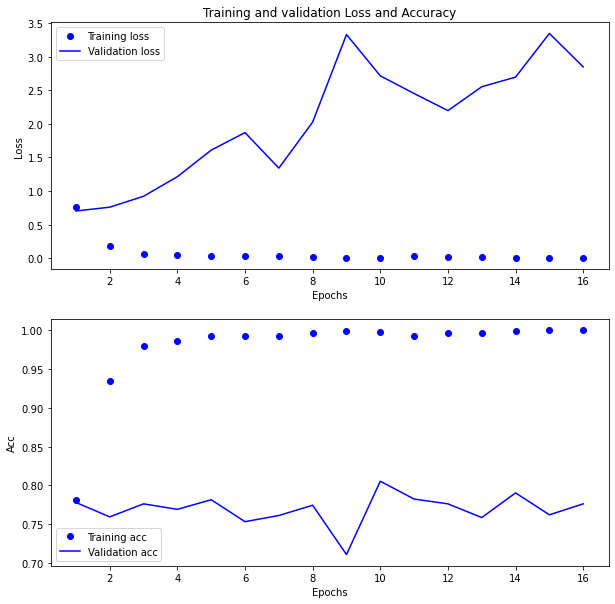

In [26]:
# Training curves
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [27]:
# Load the best saved model
from tensorflow.keras.models import load_model

model = load_model('model.h5')

In [28]:
# Using the validation dataset
score = model.evaluate_generator(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
Val loss: 0.6986339092254639
Val accuracy: 0.7791411280632019


In [29]:
# Using the test dataset
score = model.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.43178462982177734
Test accuracy: 0.8504958152770996


In [30]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Instructions for updating:
Please use Model.predict, which supports generators.
Classification Report
              precision    recall  f1-score   support

      glioma       0.86      0.79      0.82       300
  meningioma       0.74      0.61      0.67       306
     notumor       0.90      0.98      0.94       405
   pituitary       0.86      0.98      0.92       300

    accuracy                           0.85      1311
   macro avg       0.84      0.84      0.84      1311
weighted avg       0.84      0.85      0.84      1311



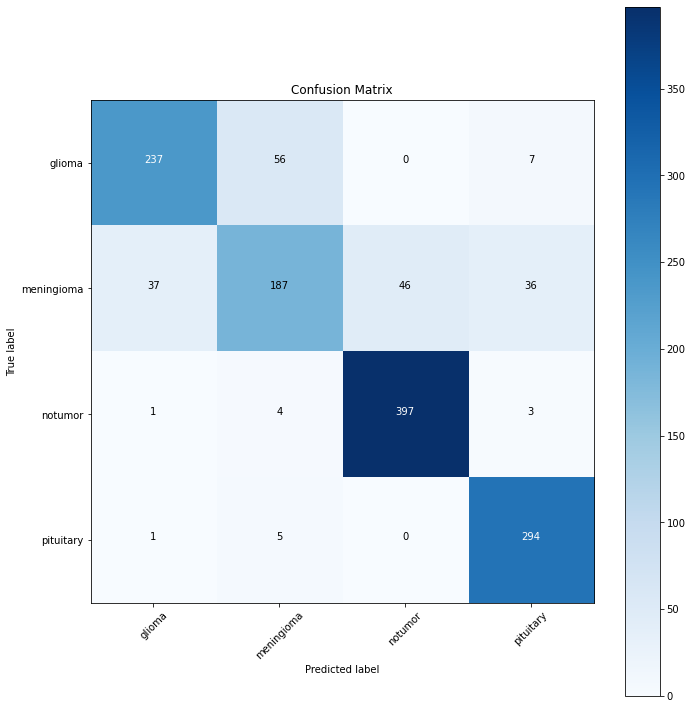

In [31]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#On test dataset
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

#Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [32]:
from tensorflow.python.client import device_lib

In [34]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9642248518716343
]
